量子ソフトウェア勉強会:「量子インスパイアード古典アルゴリズム」ハンズオン資料 2  
2023年9月20日(水)
高比良宗一（名城大学情報工学部情報工学科）
$$
\newcommand{\norm}[1]{\lVert#1\rVert}
\renewcommand{\top}{\mathsf{T}}
\newcommand{\SQ}{\mathrm{SQ}}
$$
# $x = A^+b$に関する量子インスパイアード古典アルゴリズム Part 1
### (行列$C$の特異値分解まで)

このノートブックでは，量子インスパイアード古典アルゴリズムにおける，$A$から構成される行列$C$を得るまでの部分，及びその特異値分解について実装します．そして$C$の左特異ベクトル$w^{(\ell)}$と特異値$\tilde{\sigma}$によって，$A$の左右の特異ベクトルと特異値が近似される様子を確認してみます．

## 行列$A$を定義する
低ランク行列$A$を生成する関数を定義します．

In [2]:
import random
import cmath, math
import time
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt

def low_rank_matrix(m, n, rank, cond=10):

    """
    ランクが`rank`で，条件数が`cond`であるような m x n の実行列を生成する．
    ここで条件数とは最大特異値/最小特異値である．したがってrank=1のときは条件数の値は1になる．
    
    """
    
    U, _  = np.linalg.qr(np.random.rand(m, m))
    Vh, _ = np.linalg.qr(np.random.rand(n, n))
    
    if rank==1:
        diag = np.array([cond])
        
    elif rank==2: 
        diag = np.array([1, 1/cond])
    else:
        diag = [random.uniform(1/cond, 1) for i in range(rank)]
        diag[1] = 1
        diag[2] = 1/cond
    
    return U[:,:rank] @ np.diag(diag) @ Vh[:rank,:]

In [33]:
m, n = 400, 300
A = low_rank_matrix(m, n, 2, 8)

rankA = np.linalg.matrix_rank(A)
normF = np.linalg.norm(A)
norm2 = np.linalg.norm(A, 2) 
svdvals = sp.linalg.svdvals(A)
condnumber = max(svdvals[:rankA])/min(svdvals[:rankA])

print("Aのランク =", rankA)
print("Aのフロべニウスノルム =", normF)
print("Aの2ノルム =", norm2)
print("Aの特異値\n", svdvals)
print("Aの条件数\n", condnumber)

Aのランク = 2
Aのフロべニウスノルム = 1.0077822185373184
Aの2ノルム = 0.9999999999999997
Aの特異値
 [1.00000000e+00 1.25000000e-01 5.19213071e-16 4.79118019e-16
 4.71713714e-16 4.58222417e-16 4.18376202e-16 3.81834822e-16
 3.54408030e-16 3.47628970e-16 3.21416227e-16 3.06267277e-16
 2.94596201e-16 2.77563960e-16 2.60622934e-16 2.58545313e-16
 2.29930845e-16 2.29601626e-16 2.19035211e-16 2.08345819e-16
 2.02803805e-16 1.74125391e-16 1.59430441e-16 1.47403420e-16
 1.44858870e-16 1.29917459e-16 1.17028191e-16 1.00297735e-16
 9.37942832e-17 8.61352464e-17 8.54481002e-17 8.25804231e-17
 8.02026027e-17 7.59935124e-17 6.71003385e-17 6.55470690e-17
 6.29616202e-17 5.99590794e-17 5.90842981e-17 5.83481073e-17
 5.42559429e-17 5.32616988e-17 5.20634581e-17 4.88518527e-17
 4.77845279e-17 4.71140163e-17 4.53903152e-17 4.34603235e-17
 4.18865006e-17 4.11653036e-17 4.03700291e-17 3.93219745e-17
 3.78008155e-17 3.61795232e-17 3.48760210e-17 3.44060987e-17
 3.21714941e-17 3.18224187e-17 3.15013830e-17 3.09899747e-17
 3.0503

行列$A$の特異値分解の結果を保存しておきます．

In [34]:
exact_U, exact_S, exact_Vh = np.linalg.svd(A)
exact_V = exact_Vh.T

# $\mathrm{SQ}(A)$を定義する．
`quantum_inspired.py`に`1_データ構造.ipynb`で実装した`SegmentTree`, `VectorBasedDataStructure`と`MatrixBasedDataStructure`を記述しています．ここから`MatrixBasedDataStructure`をインポートし，それを用いて行列に基づくデータ構造$\SQ(A)$を用意します．

In [35]:
from quantum_inspired import MatrixBasedDataStructure
SQA = MatrixBasedDataStructure(A)

In [36]:
SQA.sample1(), SQA.sample2(0), SQA.query(0, 0), SQA.norm(0), SQA.normF()

(209, 138, 0.0017541011869238918, 0.06069818774819866, 1.0077822185373182)

# Step 1. 行添字のサンプリング: $R^\mathsf{T} R \approx A^\mathsf{T}A$を満たすような$R$を考える．
## 行添字をサンプルする関数の実装
Step 1の「確率$\frac{\norm{A_{i,\ast}}^2 }{\norm{A}_\mathrm{F}^2}$行添字$i$を$r$回サンプリングする」という部分について実装します．これは，$\mathrm{SQ}(A)$の$\mathrm{Sample1}()$を$r$回用いるだけなので，その通りに書きます．ここでの行添字$i_0,\dots,i_{r-1}$は行列$R$を表します．

In [37]:
# Step 1
# rはサンプル数
def sample_rows(SQA, r): 
    row_indices = []
    for s in range(r):
        i_s = SQA.sample1()
        row_indices.append(i_s)    
    return row_indices

In [38]:
r = 10
row_indices = sample_rows(SQA, r)

In [39]:
print("サンプルされた行添字:\n[i_0, i_1, ..., i_r-1] = ", row_indices)

サンプルされた行添字:
[i_0, i_1, ..., i_r-1] =  [238, 48, 264, 8, 265, 55, 114, 131, 238, 289]


## $A^\top A \approx R^\top R$の確認
量子インスパイアード古典アルゴリズムでは$r\times n$の行列$R$を実際には構成しません．しかし，サンプルされた行添字が表す行列$R$について，$A^\mathsf{T}A \approx R^\mathsf{T}R$であるかどうか気になると思います．そこで，行列$R$をサンプルされた行添字から構成する関数`construct_R`を以下のセルで定義し，$A^\top A$と$R^\top R$を直接計算して$A^\top A \approx R^\top R$であることを確認してみます．`row_indices`はサンプルされた行添字です．

In [40]:
# サンプルされた行添字からRを構成する
# 確認用
def construct_R(SQA, A, row_indices):
    r = len(row_indices)
    n = A.shape[1]
    R = np.zeros((r, n))
    for s in range(r):
        i_s = row_indices[s]
        R[s,:] = (SQA.normF()/math.sqrt(r)) * A[i_s,:]/SQA.norm(i_s)
    return R

この関数`construct_R`を使って行列$R$を作り，$A^\top A \approx R^\top R$であることを確認してみます．

In [41]:
r = 10
row_indices = sample_rows(SQA, r)
R = construct_R(SQA, A, row_indices)

error = np.linalg.norm(A.T @ A - R.T @ R)
print("誤差", error)

誤差 0.02244468398310593


さらに，$\mathbb{E}\left[ \lVert R^\top R - A^\top A \rVert_\mathrm{F}^2  \right] \le \frac{\lVert A \rVert_\mathrm{F}^4}{r}$であることを確認します．具体的には，$r$を増やしてみて，誤差$\lVert R^\top R - A^\top A \rVert_\mathrm{F}^2$が減少することを見てみます．

In [42]:
sample_size = 10

errors = []

rs = [2**k for k in range(12)]
for r in rs:
    mean = 0
    for _ in range(sample_size):
        row_indices = sample_rows(SQA, r)
        R = construct_R(SQA, A, row_indices)
        
        mean += np.linalg.norm(R.T @ R - A.T @ A)**2  
        
    mean = mean/sample_size
    errors.append(mean)

    print(f"r={r}", mean, np.linalg.norm(A)**4/r)

r=1 0.011036088608588065 1.031494140624999
r=2 0.012900277652816452 0.5157470703124994
r=4 0.004301352915359831 0.2578735351562497
r=8 0.002086925152078077 0.12893676757812486
r=16 0.002153392048352806 0.06446838378906243
r=32 0.0009459364084887019 0.032234191894531215
r=64 0.0002901357148178583 0.016117095947265608
r=128 0.00025792208961707787 0.008058547973632804
r=256 0.00019129401249491832 0.004029273986816402
r=512 8.136658623254179e-05 0.002014636993408201
r=1024 4.0273416560124284e-05 0.0010073184967041005
r=2048 1.6310662494746377e-05 0.0005036592483520502


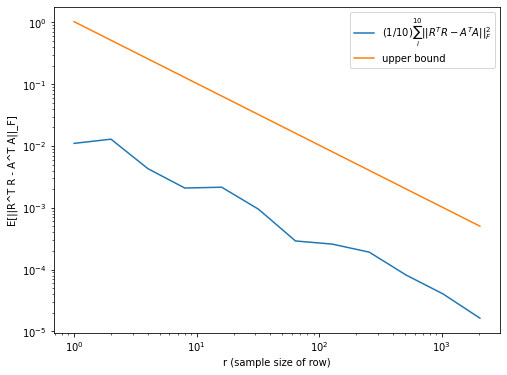

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(rs, errors, label="$(1/10)\sum_i^{10} || R^T R - A^T A ||_F^2$")
plt.plot(rs, [np.linalg.norm(A)**4/r for r in rs], label="upper bound")
plt.xlabel("r (sample size of row)")
plt.ylabel("E[||R^T R - A^T A||_F]")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

なお，関数`construct_R`はただの確認用なので，実際には使われないことに注意してください．

In [45]:
np.linalg.norm(R[0,:]), np.linalg.norm(R[1,:]), np.linalg.norm(A)/math.sqrt(r), np.linalg.norm(R), np.linalg.norm(A)

(0.022269051271467524,
 0.022269051271467524,
 0.02226905127146753,
 1.0077822185373182,
 1.0077822185373184)

# Step 2. 列のサンプリング：$CC^\top \approx RR^\top$を満たすような$C$を構成する．
次に，Step2について実装します．
## 列添字をサンプルする関数の実装
Step 2の「等確率で${0,1,\dots,r-1}$から数字をサンプリングし結果を$s$とする．そして確率$\frac{R_{s,j}^2}{\norm{R_{s,\ast}}^2} = \frac{A_{i_s,j}^2}{\norm{A_{i_s,\ast}}^2}$で列添字をサンプリングし，結果を$j_t$とする．この操作を$c$回行い，サンプリングされた列添字を$j_0,\dots,j_{c-1}$とする」の部分について実装します．


In [46]:
def sample_cols(SQA, row_indices, c):
    r = len(row_indices)
    col_indices = []
    for t in range(c):
        s   = np.random.randint(r)
        i_s = row_indices[s]
        j_t = SQA.sample2(i_s)
        col_indices.append(j_t)
        
    return col_indices

In [48]:
r = 10
row_indices = sample_rows(SQA, r)

c = 20
col_indices = sample_cols(SQA, row_indices, c)

print("サンプルされた列添字:\n[j_0, i_1, ..., j_c-1] = ", col_indices)

サンプルされた列添字:
[j_0, i_1, ..., j_c-1] =  [12, 290, 76, 146, 2, 287, 150, 48, 182, 114, 182, 194, 122, 247, 243, 47, 76, 41, 198, 206]


## $r \times c$の行列$C$を構成する関数の実装
Step2の「$r \times c$の行列$C$を第$t$列が
$\frac{\norm{R}_\mathrm{F}}{\sqrt{c}} \frac{R_{\ast,j_t}}{\norm{R_{\ast,j_t}}} = \frac{\norm{A}_\mathrm{F}}{\sqrt{c}} \frac{R_{\ast,j_t}}{\norm{R_{\ast,j_t}}}$」となるように構成する」という部分について実装します．
$R_{\ast,j_t}$について注目します．行列$R$の$s$行目は$\frac{\norm{A}_\mathrm{F}}{\sqrt{r}} \frac{A_{i_s,\ast}}{\norm{A_{i_s,\ast}}}$であるので，
行列$R$の第$j_t$列$R_{\ast,j_t}$は
$$
 R_{\ast, j_t} = \frac{\norm{A}_\mathrm{F}}{\sqrt{r}} 
 \left(
 \frac{A_{i_0,\ast}}{\norm{A_{i_0,j_t}}}, 
 \frac{A_{i_1,\ast}}{\norm{A_{i_1,j_t}}},\dots,
  \frac{A_{i_{r-1},\ast}}{\norm{A_{i_{r-1},j_t}}}, 
\right)^\top
$$
となります．このことを踏まえると，行列$C$を構成する関数は次のようになります．

In [49]:
def construct_C(SQA, row_indices, col_indices):
    normAF = SQA.normF()
    r, c = len(row_indices), len(col_indices)

    # 行列Cを構成する
    C = np.zeros((r, c))
    for t in range(c):
        
        # Rのj_t列を構成する
        R_jt = np.zeros(r)        
        j_t = col_indices[t]
        for s in range(r):
            i_s = row_indices[s]
            R_jt[s] = (normAF/(math.sqrt(r) * SQA.norm(i_s))) * SQA.query(i_s, j_t)
            
        # Cのt列を構成
        C[:, t] = (normAF/math.sqrt(c)) * R_jt/np.linalg.norm(R_jt)
        
    return C

##  $CC^\top \approx RR^\top$の確認
$CC^\top \approx RR^\top$であることを前述と時と同様にして確認してみます．

In [56]:
r, c = 10, 20

In [57]:
row_indices = sample_rows(SQA, r)
col_indices = sample_cols(SQA, row_indices, c)

R = construct_R(SQA, A, row_indices)
C = construct_C(SQA, row_indices, col_indices)

error = np.linalg.norm(R @ R.T - C @ C.T)
print("誤差", error)

誤差 0.12079629623014908


$\mathbb{E}\left[ \lVert RR^\top - AA^\top \rVert_\mathrm{F}^2  \right] \le \frac{\lVert R \rVert_\mathrm{F}^4}{c}$であることを確認します．具体的には，$c$を増やしてみて，誤差$\lVert RR^\top - AA^\top  \rVert_\mathrm{F}^2$が減少することを見てみます．

In [58]:
sample_size = 10

# E(R R.T) = C C.Tを確認する

# Rを作る
r = 10
row_indices = sample_rows(SQA, r)
R = construct_R(SQA, A, row_indices)

cs = [2**i for i in range(10)]

errors = []
for c in cs:
    mean = 0    
    for _ in range(sample_size):
        # Cを作る
        col_indices = sample_cols(SQA, row_indices, c)
        C = construct_C(SQA, row_indices, col_indices)
    
        mean += np.linalg.norm(R @ R.T - C @ C.T)**2

    mean = mean/sample_size
    errors.append(mean)

    print(f"c={c}", mean, np.linalg.norm(R)**4/c)    

c=1 0.0439018565995124 1.0314941406249971
c=2 0.01231327307140965 0.5157470703124986
c=4 0.0027570746630107973 0.2578735351562493
c=8 0.0015392452097097507 0.12893676757812464
c=16 0.002100567090502002 0.06446838378906232
c=32 0.0005925130682599771 0.03223419189453116
c=64 0.00026716441867974096 0.01611709594726558
c=128 0.00017349561289635792 0.00805854797363279
c=256 0.0001212114849485813 0.004029273986816395
c=512 5.384591647598512e-05 0.0020146369934081975


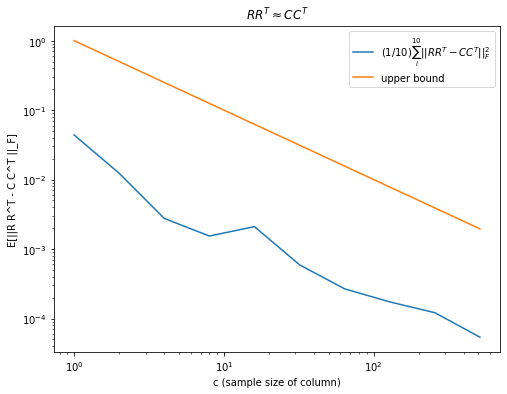

In [59]:
plt.figure(figsize=(8, 6))
plt.plot(cs, errors, label="$(1/10)\sum_i^{10} || RR^T - CC^T ||_F^2$")
plt.plot(cs, [1/c for c in cs], label="upper bound")
plt.xlabel("c (sample size of column)")
plt.ylabel("E[||R R^T - C C^T ||_F]")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$RR^T\approx CC^T$")
plt.legend()
plt.show()

# Step 3:特異値分解
最後に，Step3について考えます．Step3は行列$C$を特異値分解をするだけなのであり，この部分はNumPyの関数を使います  ．
<!-- $r,c$は行列$A$の次元には関係しないことに注意してください． -->

In [62]:
def qi_svd(SQA, r, c):
    
    # Step 1
    row_indices = sample_rows(SQA, r)
    
    # Step 2
    col_indices = sample_cols(SQA, row_indices, c)
    C = construct_C(SQA, row_indices, col_indices)
    
    # Step 3
    W, S, _ = np.linalg.svd(C)
    
    return row_indices, W, S

r, c = 100, 100
row_indices, W, S = qi_svd(SQA, r, c)
print("{i_0,...i_r-1} = \n", row_indices)
print("left singular vector of C =\n", W)
print("singular values of C =\n", S)

{i_0,...i_r-1} = 
 [79, 131, 236, 138, 78, 41, 85, 354, 123, 169, 337, 258, 140, 76, 150, 308, 235, 238, 96, 231, 138, 258, 308, 211, 254, 260, 36, 307, 199, 195, 186, 124, 305, 85, 227, 323, 8, 129, 383, 8, 246, 132, 59, 145, 84, 129, 80, 129, 316, 95, 30, 11, 1, 211, 155, 271, 129, 106, 30, 5, 155, 256, 367, 266, 304, 182, 146, 195, 194, 55, 314, 4, 109, 186, 383, 220, 199, 220, 371, 159, 238, 153, 354, 289, 132, 314, 304, 181, 68, 55, 333, 229, 143, 231, 168, 35, 234, 137, 137, 79]
left singular vector of C =
 [[-0.10078665  0.05567284  0.32115091 ... -0.00234017  0.00356132
   0.93119914]
 [-0.09960004 -0.07489795  0.1081485  ... -0.01584392  0.02411162
  -0.04766102]
 [-0.09953486 -0.07910364 -0.05188662 ...  0.00095203 -0.00144882
   0.01363859]
 ...
 [-0.09931901 -0.09232038 -0.08066682 ... -0.09563616  0.14554116
   0.03532856]
 [-0.09931901 -0.09232038 -0.08066682 ...  0.08259732 -0.12569838
   0.03532856]
 [-0.10078665  0.05567284  0.05176083 ... -0.02035416  0.03097539
  -0.

# $C$の特異値・特異ベクトルと$A$の特異値・特異ベクトルについて

## 特異値について
上記のアルゴリズムで得られた$C$の特異値$\tilde{\sigma}_\ell$(`S`)が，行列$A$の特異値$\sigma_\ell$(`exact_S`)を近似していることを見てみます．

In [63]:
r, c = 20, 20
_, _, S = qi_svd(SQA, r, c)
print(f"{m}x{n}の行列Aの特異値: \n", exact_S)
print(f"\n{r}x{c}の行列Cの特異値: \n", S)

400x300の行列Aの特異値: 
 [1.00000000e+00 1.25000000e-01 5.19213094e-16 4.79345167e-16
 4.71732210e-16 4.58242570e-16 4.18376202e-16 3.81834821e-16
 3.51484432e-16 3.47825823e-16 3.15975052e-16 3.06894888e-16
 2.92151597e-16 2.76922056e-16 2.60478793e-16 2.58559675e-16
 2.32224610e-16 2.30232802e-16 2.14765425e-16 2.08972139e-16
 2.02095864e-16 1.59139236e-16 1.54982739e-16 1.45129604e-16
 1.28041119e-16 1.23098986e-16 1.21378664e-16 9.86021132e-17
 9.71529166e-17 9.71529166e-17 9.71529166e-17 9.71529166e-17
 9.71529166e-17 9.71529166e-17 9.71529166e-17 9.71529166e-17
 9.71529166e-17 9.71529166e-17 9.71529166e-17 9.71529166e-17
 9.71529166e-17 9.71529166e-17 9.71529166e-17 9.71529166e-17
 9.71529166e-17 9.71529166e-17 9.71529166e-17 9.71529166e-17
 9.71529166e-17 9.71529166e-17 9.71529166e-17 9.71529166e-17
 9.71529166e-17 9.71529166e-17 9.71529166e-17 9.71529166e-17
 9.71529166e-17 9.71529166e-17 9.71529166e-17 9.71529166e-17
 9.71529166e-17 9.71529166e-17 9.71529166e-17 9.71529166e-17
 9.71

サンプル数$r,c$を増やしたときの特異値に関する誤差についてみてみます．行列$A$のランク分だけ$C$の特異値に注目します．

In [66]:
sample_size = 10

rs = [2**i for i in range(1, 10)]
cs = [2**i for i in range(1, 10)]

hist0 = []
hist1 = []
for r, c in zip(rs, cs):
    mean0 = 0
    mean1 = 0
    for _ in range(sample_size):
        _, _, S = qi_svd(SQA, r, c)
        mean0 += abs(S[0] - exact_S[0])
        mean1 += abs(S[1] - exact_S[1])
        
    mean0 = mean0/sample_size
    mean1 = mean1/sample_size
    hist0.append(mean0)
    hist1.append(mean1)
    
    print(f"(r,c)=({r},{c}):", mean0, mean1)

(r,c)=(2,2): 0.007605164936364128 0.10077677401493898
(r,c)=(4,4): 0.006664163493095154 0.08303654467706957
(r,c)=(8,8): 0.011376142261109523 0.07973403408947627
(r,c)=(16,16): 0.009745271459953176 0.06004110776570289
(r,c)=(32,32): 0.003609230642555905 0.031184591754424763
(r,c)=(64,64): 0.004273053488123823 0.03890602246205678
(r,c)=(128,128): 0.002837380586722571 0.024082138257608424
(r,c)=(256,256): 0.00208143073207121 0.018202510064449937
(r,c)=(512,512): 0.0017952579212976772 0.014526341778711576


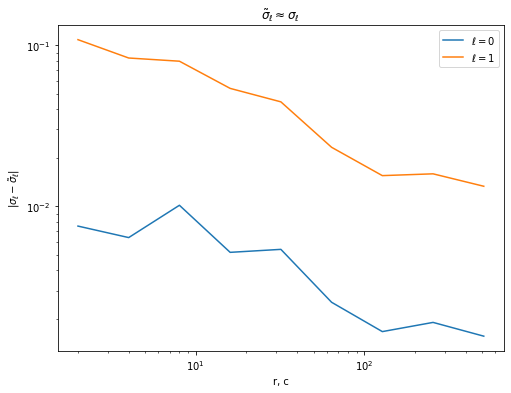

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(rs, hist0, label=r"$\ell=0$")
plt.plot(rs, hist1, label=r"$\ell=1$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r, c")
plt.ylabel(r"$|\sigma_\ell - \tilde{\sigma}_\ell|$")
plt.title(r"$\tilde{\sigma}_\ell \approx \sigma_\ell$")
plt.legend()
plt.show()

なお，サンプル数$r,c$が行列$A$のサイズよりも小さい場合，$C$のサイズは$A$のサイズよりも小さくなります．そのため，$A$の特異値をそのまま計算するよりも，高速に近似特異値を得ることが期待できます．($\mathrm{SQ}(A)$の構築時間を含めれると，遅くなることに注意)

In [74]:
import time

start_time = time.time()
exact_S = sp.linalg.svdvals(A)
print("SciPyの特異値計算の時間\n", time.time() - start_time)

start_time = time.time()
# SQA = MatrixBasedDataStructure(A) # SQ(A)の構築も含めると遅くなる
_, _, S = qi_svd(SQA, 10, 10)
print("qi_svdを用いた時の特異値計算の時間\n", time.time() - start_time)

print("特異値の誤差", np.abs(exact_S[:2] - S[:2]))

SciPyの特異値計算の時間
 0.017342090606689453
qi_svdを用いた時の特異値計算の時間
 0.0013911724090576172
特異値の誤差 [0.00457841 0.04470537]


## 右特異ベクトルについて
行列$A$の右特異ベクトル$v^{(\ell)}$は，
$$
    v^{(\ell)} \approx \tilde{v}^{(\ell)} = \frac{1}{\tilde{\sigma}_\ell}R^\dagger\vec{w}^{(\ell)}
$$のようにして近似されます．このことを確認してみましょう．

In [75]:
r, c = 100, 100
row_indices, W, S = qi_svd(SQA, r, c)

R = construct_R(SQA, A, row_indices)

In [76]:
v0 = R.T @ W[:,0] / S[0]

print("0番目の特異値に対応するAの右特異ベクトル")
print("近似:\n",   v0)
print("SciPy:\n", exact_V[:,0])

0番目の特異値に対応するAの右特異ベクトル
近似:
 [-0.0317202   0.01337399 -0.11415716  0.06198199 -0.05629502 -0.03856402
  0.07927241 -0.05296198  0.02053256  0.07143687 -0.06066683  0.06599246
  0.08793431 -0.05312667  0.051438   -0.01644564 -0.05498971  0.03757013
 -0.00098816  0.02539686  0.06564687 -0.00855814 -0.0259037  -0.05998523
  0.05305378  0.08943291  0.07003928  0.00999123  0.04687588  0.00265625
 -0.09704059  0.07938635 -0.01840886  0.06111095 -0.06052255 -0.07395583
 -0.0521981   0.11650144 -0.09268968  0.07901958  0.02008417  0.08155085
 -0.04346777  0.01810488  0.03339253  0.05137885 -0.03231164  0.03518399
 -0.03111885  0.03459961  0.00977295  0.03586271 -0.10363354 -0.07319737
 -0.0802782   0.03757656  0.02940295 -0.02734621 -0.03605049 -0.0772996
  0.05253919 -0.06384619  0.01248809  0.00919471  0.08133145 -0.07976466
  0.07494208 -0.08056276 -0.07593681  0.02836961  0.04319938  0.03126609
  0.033294    0.1033259  -0.07034601  0.10302226 -0.09485786  0.08655116
  0.0194916   0.01596536 

サンプル数を増やしていくにつれて，$\norm{v^{(\ell)} - \tilde{v}^{(\ell)}}$が小さくなることを確認します．

In [79]:
errors = []
sample_size = 10
k = 0 # 確認する特異ベクトルの番号．
rs = [2**i for i in range(1, 9)]
cs = [2**i for i in range(1, 9)]

hist0 = []
hist1 = []

for r, c in zip(rs, cs):

    mean0 = 0
    mean1 = 0
    for _ in range(sample_size):
        row_indices, W, S = qi_svd(SQA, r, c)

        # 確認
        R = construct_R(SQA, A, row_indices)
        v0 = R.T @ W[:, 0]/S[0]
        v1 = R.T @ W[:, 1]/S[1]
        
        mean0 += np.linalg.norm(v0 - exact_V[:, 0])
        mean1 += np.linalg.norm(v1 - exact_V[:, 1])
        
    mean0 = mean0/sample_size
    mean1 = mean1/sample_size   
    hist0.append(mean0)
    hist1.append(mean1)
    
    print(f"(r,c)=({r},{c}):", mean0, mean1, np.abs(S[:rankA] - exact_S[:rankA]))

(r,c)=(2,2): 0.02829504908539988 11.953080497719569 [0.05143816 0.21537544]
(r,c)=(4,4): 0.037495686271958616 2.864633876497967 [0.00751327 0.10171908]
(r,c)=(8,8): 0.018633988145829013 1.7889104770224038 [0.00145007 0.01220476]
(r,c)=(16,16): 0.02246828079147237 1.2119560370589524 [0.00659683 0.07613456]
(r,c)=(32,32): 0.015194689881244009 1.1144072028039513 [0.00340926 0.03121909]
(r,c)=(64,64): 0.011350414319032538 1.0925412277833169 [0.00151848 0.01160038]
(r,c)=(128,128): 0.008898171229586123 0.8549066952643022 [0.00144013 0.01211654]
(r,c)=(256,256): 0.0041891501005805205 0.28546587539012197 [3.09644045e-05 2.47466442e-04]


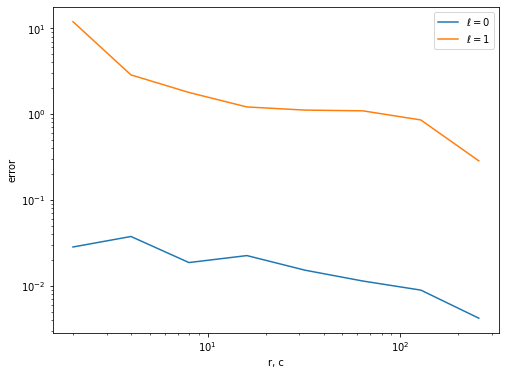

In [81]:
plt.figure(figsize=(8, 6))
plt.plot(rs, hist0, label=r"$\ell=0$")
plt.plot(rs, hist1, label=r"$\ell=1$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r, c")
plt.ylabel("error")
plt.title(r"")
plt.legend()
plt.show()

## 左特異ベクトルについて
行列$A$の左特異ベクトル$u^{(\ell)}$は，
$$
    u^{(\ell)} \approx \tilde{u}^{(\ell)} = \frac{1}{\tilde{\sigma}_\ell^2}A R^\top w^{(\ell)}
$$
のようにして近似されます．このことを確認してみます．

In [82]:
r, c = 1000, 1000
row_indices, W, S = qi_svd(SQA, r, c)
R = construct_R(SQA, A, row_indices)

In [84]:
u0 = A @ R.T @ W[:,0] / (S[0]**2)

print("0番目の特異値に対応するAの左特異ベクトル")
print("近似:\n",   u0)
print("SciPy:\n", exact_U[:,0])

0番目の特異値に対応するAの左特異ベクトル
近似:
 [-0.0605458  -0.0704849  -0.07149567 -0.04855803 -0.06494327 -0.0608823
 -0.00690812 -0.04015194 -0.07384671 -0.0734254  -0.00876735 -0.05075763
 -0.05635925 -0.03699295 -0.03174713 -0.07583245 -0.00139154 -0.02593728
 -0.07389579 -0.04645488 -0.05951348 -0.03605792 -0.05254252 -0.01226802
 -0.00362969 -0.0339557  -0.04472962 -0.0125205  -0.07404588 -0.03484445
 -0.07841977 -0.08207029 -0.05855517 -0.06039629 -0.06840638 -0.06452022
 -0.06882283 -0.02948692 -0.06494297 -0.06989275 -0.00083706 -0.07390116
 -0.06036129 -0.05834352 -0.0173526  -0.05614958 -0.04937652 -0.03994919
 -0.01978992 -0.03851737 -0.03806637 -0.08059453 -0.02387455 -0.07240957
 -0.07010345 -0.08319091 -0.00675038 -0.01602705 -0.03474378 -0.02315195
 -0.05877738 -0.01669903 -0.04517126 -0.03589944 -0.00946414 -0.08191783
 -0.03327773 -0.07096757 -0.07956595 -0.07393915 -0.03677444 -0.05498509
 -0.00635478 -0.02331074 -0.0667158  -0.0048446  -0.05927138 -0.04358965
 -0.07173062 -0.07904759 

サンプル数を増やしていくにつれて，$\norm{u^{(\ell)} - \tilde{u}^{(\ell)}}$が小さくなることを確認します．

In [85]:
sample_size = 20

hist0 = []
hist1 = []

rs = [2**i for i in range(1, 10)]
cs = [2**i for i in range(1, 10)]
for r, c in zip(rs, cs):

    mean0 = 0
    mean1 = 0
    for _ in range(sample_size):
        row_indices, W, S = qi_svd(SQA, r, c)

        # 確認
        R = construct_R(SQA, A, row_indices)
        u0 = A @ R.T @ W[:, 0]/S[0]**2 
        u1 = A @ R.T @ W[:, 1]/S[1]**2
        mean0 += np.linalg.norm(u0 - exact_U[:, 0])
        mean1 += np.linalg.norm(u1 - exact_U[:, 1])
        
    mean0 = mean0/sample_size
    mean1 = mean1/sample_size
    hist0.append(mean0)
    hist1.append(mean1)
    
    print(f"(r,c)=({r},{c}):", mean0, mean1)

(r,c)=(2,2): 0.013603883719106055 2130.2608988385095
(r,c)=(4,4): 0.014645442873687764 15.121519302163557
(r,c)=(8,8): 0.02509946525614708 10.636265086191234
(r,c)=(16,16): 0.012625600458247736 3.8287808017213267
(r,c)=(32,32): 0.007096984858864107 2.3173803313471515
(r,c)=(64,64): 0.005862771726432317 1.7957413769009574
(r,c)=(128,128): 0.004717295673775422 1.279604646308625
(r,c)=(256,256): 0.004818623948890067 1.378776675271584
(r,c)=(512,512): 0.0029659244507325017 0.9435018957612348


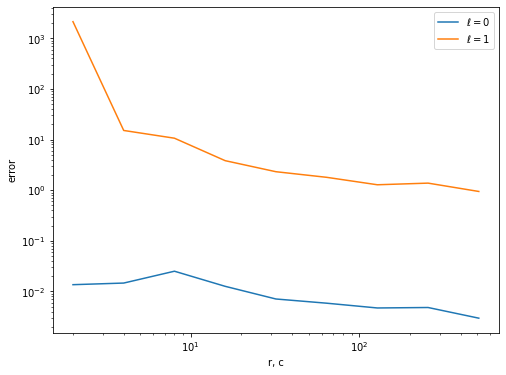

In [88]:
plt.figure(figsize=(8, 6))
plt.plot(rs, hist0, label=r"$\ell=0$")
plt.plot(rs, hist1, label=r"$\ell=1$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r, c")
plt.ylabel("error")
plt.title(r"")
plt.legend()
plt.show()

# まとめ
量子インスパイアード古典アルゴリズムにおける，$C$の特異値分解までをみてきました．このノートブックでは，特異ベクトルの復元に，行列$A$や$R$と$C$の左特異ベクトルに関する行列-ベクトル積を行なっているため，元々の行列$A$の次元に関して多項式の計算量を必要とします．`3_SQ(x).ipynb`では，このような計算量をかけずにSample, Query, Normそれぞれを実行することについて説明します．

# 参考文献
- András Gilyén, Seth Lloyd, and Ewin Tang, ''Quantum-inspired low-rank stochastic regression with logarithmic dependence on the dimension,'' arXiv:1811.04909, (2018). https://arxiv.org/abs/1811.04909

- Ewin Tang. 2019. A quantum-inspired classical algorithm for recommendation systems. In Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing (STOC 2019). Association for Computing Machinery, New York, NY, USA, 217–228. https://doi.org/10.1145/3313276.3316310